# <center>ST590 Final Project</center>

#### <center>Pramodini Karwande and Ashley Ko </center>

## Introduction

**This section is in progress. I have started writing some preliminary things that we can use to form an introductory section**



We will be exploring data from `heart.csv`. It was obtained via kaggle.com. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

We will be using this data set to classify individuals as either having heart disease or not. This is a binary data set.
We will use a classification tree, bagging, random forest and logistic regression to select and fit models and predict the presence of heart disease.

## Supervised Learning Concepts

In [ ]:
## TO DO: DESCRIBE SUPERVISED LEARNING CONCEPTS

## Data Split

In [29]:
## TO DO: CALL PACKAGES

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pandas as pd
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

<p  style="color:#ff6633;"> Now read in a data set using `pandas on spark`</p>

In [30]:
## TO DO: READ IN DATA HERE
psdf_heart = ps.read_csv("heart.csv")
psdf_heart.head()

22/04/27 21:14:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/27 21:14:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<p  style="color:#ff6633;"> Let's first see any missing values to handle the data properly. </p>

In [33]:
# check for null values
print(psdf_heart.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [31]:
# convert categorical variables into `category` type variable
psdf_heart.Sex = psdf_heart.Sex.astype("category")
psdf_heart.ChestPainType = psdf_heart.ChestPainType.astype("category")
psdf_heart.RestingECG = psdf_heart.RestingECG.astype("category")
psdf_heart.ExerciseAngina = psdf_heart.ExerciseAngina.astype("category")
psdf_heart.ST_Slope = psdf_heart.ST_Slope.astype("category")
psdf_heart.HeartDisease = psdf_heart.HeartDisease.astype("category")

psdf_heart.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int32   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int32   
 4   Cholesterol     918 non-null    int32   
 5   FastingBS       918 non-null    int32   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int32   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(6), float64(1), int32(5)

22/04/27 21:14:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/27 21:14:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [32]:
sql_heart = psdf_heart.to_spark()

In [33]:
sql_train, sql_test = sql_heart.randomSplit([0.75, 0.25], seed = 1)
print(sql_train.count(), sql_test.count())

709 209


In [35]:
pd_train = sql_train.toPandas()
pd_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,28,1,1,130,132,0,0,185,0,0.0,2,0
1,29,1,1,120,243,0,1,160,0,0.0,2,0
2,29,1,1,130,204,0,0,202,0,0.0,2,0
3,29,1,1,140,263,0,1,170,0,0.0,2,0
4,31,0,1,100,219,0,2,150,0,0.0,2,0


In [44]:
psdf_train = sql_train.to_pandas_on_spark()
psdf_train.head()

22/04/27 21:21:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/27 21:21:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,28,1,1,130,132,0,0,185,0,0.0,2,0
1,29,1,1,120,243,0,1,160,0,0.0,2,0
2,29,1,1,130,204,0,0,202,0,0.0,2,0
3,29,1,1,140,263,0,1,170,0,0.0,2,0
4,31,0,1,100,219,0,2,150,0,0.0,2,0


## Exploratory Data Analysis

### Numerical Summaries

<p  style="color:#ff6633;"> Using pandas-on-Spark, below is the summary for the variables : `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak` variables </p>

In [45]:
psdf_train[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,709.000000,709.000000,709.000000,709.000000,709.000000
mean,53.605078,132.344147,198.088858,136.685472,0.862341
std,9.378680,19.005576,111.363249,25.214079,1.054198
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,172.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.500000
75%,60.000000,140.000000,267.000000,155.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<p  style="color:#ff6633;"> Let's repeat above task to get mean and std for the given variables for HeartDisease based on sex. </p>

In [46]:
psdf_train_summ_group = psdf_train.groupby('HeartDisease').agg({'Age': ['mean', 'std'], \
                                  'RestingBP': ['mean', 'std'], 'Cholesterol': ['mean', 'std'], \
                                  'MaxHR': ['mean', 'std'], 'Oldpeak': ['mean', 'std'] \
                          })
psdf_train_summ_group

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak         
                   mean       std        mean        std        mean         std        mean        std      mean      std
HeartDisease                                                                                                              
1             55.842784  8.786796  133.858247  20.266136  173.471649  129.195270  127.886598  23.645149  1.256959  1.14356
0             50.900312  9.371634  130.514019  17.214292  227.844237   75.032039  147.320872  22.871513  0.385358  0.67842

In [47]:
psdf__train_summ_sex = psdf_train.groupby('Sex').agg({'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], \
                                'Cholesterol': ['mean', 'std'], 'MaxHR': ['mean', 'std'], \
                                  'Oldpeak': ['mean', 'std'] \
                          })
psdf_train_summ_sex

NameError: name 'psdf_train_summ_sex' is not defined

C:\Users\kar_d\anaconda3\lib\site-packages\pyspark\pandas\indexes\base.py:589: UserWarning:

We recommend using `CategoricalIndex.to_numpy()` instead.

C:\Users\kar_d\anaconda3\lib\site-packages\pyspark\pandas\generic.py:638: UserWarning:

We recommend using `Series.to_numpy()` instead.



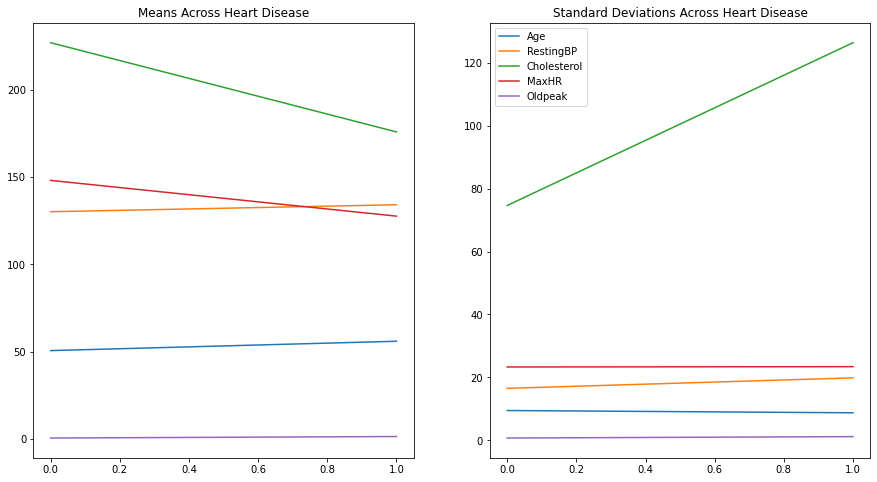

In [67]:
# Using plots, we will observe the trend of means and std across the age

figure, axis = plt.subplots(1, 2,figsize=(15, 8))

axis[0].plot(psdf_heart_summ_group[('Age', 'mean')], label = "Age")
axis[0].plot(psdf_heart_summ_group[('RestingBP', 'mean')], label = "RestingBP")
axis[0].plot(psdf_heart_summ_group[('Cholesterol', 'mean')], label = "Cholesterol")
axis[0].plot(psdf_heart_summ_group[('MaxHR', 'mean')], label = "MaxHR")
axis[0].plot(psdf_heart_summ_group[('Oldpeak', 'mean')], label = "Oldpeak")

axis[0].set_title("Means Across Heart Disease")

axis[1].plot(psdf_heart_summ_group[('Age', 'std')], label = "Age")
axis[1].plot(psdf_heart_summ_group[('RestingBP', 'std')], label = "RestingBP")
axis[1].plot(psdf_heart_summ_group[('Cholesterol', 'std')], label = "Cholesterol")
axis[1].plot(psdf_heart_summ_group[('MaxHR', 'std')], label = "MaxHR")
axis[1].plot(psdf_heart_summ_group[('Oldpeak', 'std')], label = "Oldpeak")

axis[1].set_title("Standard Deviations Across Heart Disease")

plt.legend()

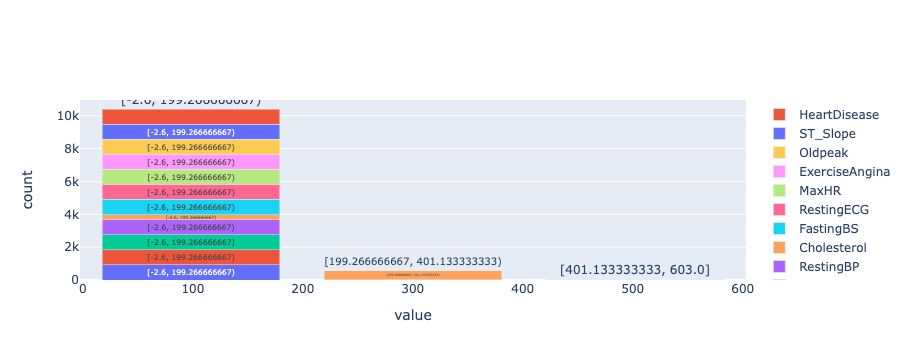

In [73]:
psdf_heart.plot.hist(bins=3, alpha=0.5)


In [48]:
psdf_train.corr()

22/04/27 21:22:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/27 21:22:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
Age,1.000000,0.040197,-0.051000,0.235575,-0.086817,0.202278,-0.044080,-0.388708,0.221259,0.262808,-0.293949,0.262501
Sex,0.040197,1.000000,-0.101738,0.006201,-0.192004,0.108920,0.054993,-0.148281,0.170823,0.102542,-0.145496,0.292780
ChestPainType,-0.051000,-0.101738,1.000000,-0.011139,0.067892,-0.073750,-0.052836,0.278571,-0.365515,-0.159314,0.188211,-0.358870
RestingBP,0.235575,0.006201,-0.011139,1.000000,0.104891,0.092913,0.029914,-0.116409,0.157030,0.165918,-0.075774,0.087648
Cholesterol,-0.086817,-0.192004,0.067892,0.104891,1.000000,-0.270529,-0.219901,0.227093,-0.026082,0.040038,0.133044,-0.243202
FastingBS,0.202278,0.108920,-0.073750,0.092913,-0.270529,1.000000,0.067022,-0.119400,0.045871,0.046599,-0.176737,0.257040
RestingECG,-0.044080,0.054993,-0.052836,0.029914,-0.219901,0.067022,1.000000,-0.159454,0.040487,-0.055667,0.020291,0.035419
MaxHR,-0.388708,-0.148281,0.278571,-0.116409,0.227093,-0.119400,-0.159454,1.000000,-0.372242,-0.162096,0.338005,-0.383932
ExerciseAngina,0.221259,0.170823,-0.365515,0.157030,-0.026082,0.045871,0.040487,-0.372242,1.000000,0.406332,-0.414019,0.475131
Oldpeak,0.262808,0.102542,-0.159314,0.165918,0.040038,0.046599,-0.055667,-0.162096,0.406332,1.000000,-0.510902,0.411836


### Graphical Summaries

## Modeling

### Transformations

In [11]:
from pyspark.ml.feature import SQLTransformer

In [12]:
sqlTrans = SQLTransformer(
    statement = "SELECT Age, Sex, ChestPainType, log(RestingBP) as log_RestingBP," + 
                "log(Cholesterol) as log_Cholesterol, FastingBS, RestingECG," +
                "log(MaxHR) as log_MaxHR, ExerciseAngina, Oldpeak, ST_Slope," +
                "HeartDisease as label FROM __THIS__"
)

In [13]:
sqlTrans.transform(sql_heart).show(5)

+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+-----+
|Age|Sex|ChestPainType|     log_RestingBP|  log_Cholesterol|FastingBS|RestingECG|        log_MaxHR|ExerciseAngina|Oldpeak|ST_Slope|label|
+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+-----+
| 40|  1|            1| 4.941642422609304|5.666426688112432|        0|         1|5.147494476813453|             0|    0.0|       2|    0|
| 49|  0|            2| 5.075173815233827| 5.19295685089021|        0|         1|5.049856007249537|             0|    1.0|       1|    1|
| 37|  1|            1| 4.867534450455582|5.645446897643238|        0|         2|4.584967478670572|             0|    0.0|       2|    0|
| 48|  0|            0| 4.927253685157205|5.365976015021851|        0|         1| 4.68213122712422|             1|    1.5|       1|    1|
| 54|  1|            2|5.010635294

In [14]:
from pyspark.ml.feature import VectorAssembler

In [17]:
assembler = VectorAssembler(inputCols = ["Age", "Sex", "ChestPainType", "log_RestingBP", "log_Cholesterol",
                                         "FastingBS", "RestingECG", "log_MaxHR", "ExerciseAngina", "Oldpeak",
                                         "ST_Slope"],
                            outputCol = "features", handleInvalid = 'keep')

In [19]:
assembler.transform(
    sqlTrans.transform(sql_heart)
).select("label", "features").show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[40.0,1.0,1.0,4.9...|
|    1|[49.0,0.0,2.0,5.0...|
|    0|[37.0,1.0,1.0,4.8...|
|    1|[48.0,0.0,0.0,4.9...|
|    0|[54.0,1.0,2.0,5.0...|
+-----+--------------------+
only showing top 5 rows



### Models

In [ ]:
### Classification Tree

In [ ]:
### Random Forest

## Conclusion